In [1]:
#import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD

from sklearn.metrics import pairwise_distances

import pymongo
from pymongo import MongoClient

In [2]:
# Initialize mongoDB client
client = MongoClient()
db = client.yelp

In [3]:
# Gather businesses data from DB
# create new collection with split categories
db.temp_businesses.drop()
agr = [{'$project': {'business_id':1,'name':1,'address':1,'city':1,'state':1,'postal_code':1,'latitude':1,'longitude':1,'stars':1,'review_count':1,'is_open':1,'attributes':1,'categories': {'$split':["$categories",","]},'hours':1}},{'$out': 'temp_businesses'}]
businesses_agr = db.businesses.aggregate(agr)
businesses_collection = db.temp_businesses
businesses_df = pd.DataFrame(list(businesses_collection.find()))
businesses_count = businesses_df.shape[0]

In [4]:
# Obtain random business from businesses dataframe
random_number = np.random.randint(1,businesses_count)
business = businesses_df.iloc[random_number]
business

_id                                      5e9d2e48b9b6753aca07c943
business_id                                xeHaI3Qguo5YpeR0vh7hGg
name                                                   Pizza Nova
address                              520 Wilson Heights Boulevard
city                                                      Toronto
state                                                          ON
postal_code                                               M3H 2V6
latitude                                                  43.7507
longitude                                                -79.4564
stars                                                         2.5
review_count                                                    3
is_open                                                         1
attributes      {'RestaurantsAttire': ''casual'', 'GoodForKids...
hours           {'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', ...
categories                        [Italian,  Restaurants,  Pizza]
Name: 1250

In [5]:
# Get categories array
categories = business.get('categories')

In [6]:
# Get Businesses in categories ($all for all in categories, $in for any in categories)
businesses_in_categories_df = pd.DataFrame(list(businesses_collection.find({ "categories": {"$all": categories} })))
business_ids_in_categories = businesses_in_categories_df['business_id'].tolist()

In [7]:
# Now obtain all useful (greater than zero) reviews from the group of businesses_in_categories_df
reviews_df = pd.DataFrame(list(db.reviews.find({'business_id': {'$in': business_ids_in_categories}, 'useful': {'$gt': 0}})))
reviews_df.stars = reviews_df.stars.astype('int')

In [8]:
# Create Surprise data
reader = Reader( rating_scale= (1,5))
surprise_dataset = Dataset.load_from_df(reviews_df[['business_id','user_id','stars']], reader)
train_set, test = train_test_split(surprise_dataset, test_size=.3)
test_ds=Dataset.load_from_df(pd.DataFrame(test),reader)
validation_set, test_set=  train_test_split(test_ds, test_size=.15)
test_data = Dataset.load_from_df(pd.DataFrame(test_set),reader)

In [9]:
# Surprise requiere que explicitamente los datasets sean transformados a datasets de entrenamiento y prueba en cada caso 
test_data_n = test_data.build_full_trainset()
# Finalmente, se convierten los 3 datasets a prueba ya que se medirá el error obtenido en los 3
train_data_2 = train_set.build_testset()
validation_data = validation_set.build_testset()
test_data = test_data_n.build_testset()

----------- 1
Train: 0.38508075238323963
Validation: 1.412240944386855
Test: 1.3773198553745667
----------- 1
----------- 2
Train: 0.33421417576848395
Validation: 1.4084107833616288
Test: 1.3743845690624688
----------- 2
----------- 3
Train: 0.30665803724055846
Validation: 1.4060020605530315
Test: 1.3723265214198523
----------- 3
----------- 4
Train: 0.29189539769819256
Validation: 1.405982853997168
Test: 1.3764276539173639
----------- 4
----------- 5
Train: 0.2787766379031542
Validation: 1.4080572123770294
Test: 1.3688093423601788
----------- 5
----------- 6
Train: 0.27096592045231016
Validation: 1.4027736560055588
Test: 1.3769436655532696
----------- 6
----------- 7
Train: 0.26912269855544363
Validation: 1.4051001577574023
Test: 1.3709989181678066
----------- 7
----------- 8
Train: 0.2655239631686907
Validation: 1.4042638671527958
Test: 1.375301231253589
----------- 8
----------- 9
Train: 0.2575973614516704
Validation: 1.4044763620574852
Test: 1.3710938619570903
----------- 9
-------

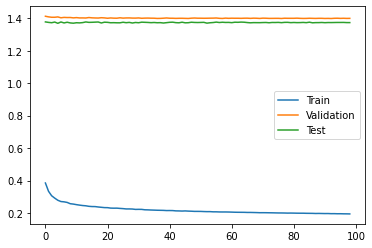

In [12]:
# Setup algorithm using SVD
# Variando el numero de factores 
rmse = []
for i in range(1,100):
    svd = SVD( n_factors = i, n_epochs = 200, biased = True, lr_all = 0.005, reg_all = 0, init_mean = 0, init_std_dev = 0.01, verbose = False )
    svd.fit(train_set)
    pu = svd.pu

    predictions_train = svd.test( train_data_2 )
    predictions_validation = svd.test( validation_data )
    predictions_test = svd.test( test_data )

    rmse_train=accuracy.rmse( predictions_train, verbose = False )
    rmse_validation=accuracy.rmse( predictions_validation, verbose = False )
    rmse_test=accuracy.rmse( predictions_test, verbose = False )

    rmse.append([rmse_train,rmse_validation,rmse_test])

    print("-----------", i)
    print("Train:", rmse_train)
    print("Validation:", rmse_validation)
    print("Test:", rmse_test)
    print("-----------", i)

df = pd.DataFrame(rmse, columns=["Train", "Validation", "Test"])
df.plot()

----------- 0
Train: 0.15840839957890826
Validation: 1.4003772954732958
Test: 1.3769822349733845
----------- 0
----------- 0.001
Train: 0.15856120928883263
Validation: 1.4020285665268475
Test: 1.3749442350309937
----------- 0.001
----------- 0.01
Train: 0.16165858319089502
Validation: 1.4011074227720104
Test: 1.3732351283257698
----------- 0.01
----------- 0.1
Train: 0.23399304294471054
Validation: 1.4051102022521402
Test: 1.3701883781461637
----------- 0.1
----------- 1
Train: 0.7726042738822365
Validation: 1.4290976612898538
Test: 1.3761051468858485
----------- 1
----------- 10
Train: 1.3427705905937122
Validation: 1.4810737997745267
Test: 1.423270439992447
----------- 10


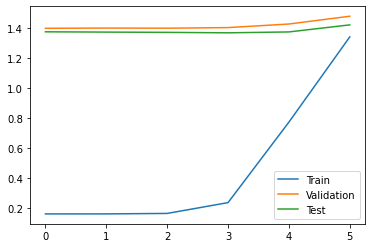

In [15]:
# Setup algorithm using SVD
# Variando la regularizacion
rmse = []   
for r in [0,0.001,0.01,0.1,1,10]:
    svd2 = SVD( n_factors = 60, n_epochs = 200, biased = True, lr_all = 0.01, reg_all = r, init_mean = 0, init_std_dev = 0.01, verbose = False )
    svd2.fit(train_set)
    pu2 = svd2.pu
    predictions_train = svd2.test( train_data_2 )
    predictions_validation = svd2.test( validation_data )
    predictions_test = svd2.test( test_data )

    rmse_train=accuracy.rmse( predictions_train, verbose = False )
    rmse_validation=accuracy.rmse( predictions_validation, verbose = False )
    rmse_test=accuracy.rmse( predictions_test, verbose = False )

    rmse.append([rmse_train,rmse_validation,rmse_test])

    print("-----------", r)
    print("Train:", rmse_train)
    print("Validation:", rmse_validation)
    print("Test:", rmse_test)
    print("-----------", r)

df = pd.DataFrame(rmse, columns=["Train", "Validation", "Test"])
df.plot()

----------- 0
Train: 1.4929132732206338
Validation: 1.5050362935602897
Test: 1.4464305365951378
----------- 0
----------- 0.001
Train: 1.0519876763910956
Validation: 1.3895167287335946
Test: 1.3479866540808947
----------- 0.001
----------- 0.01
Train: 0.15843734621601796
Validation: 1.402619793999609
Test: 1.3778412078321736
----------- 0.01
----------- 0.1
Train: 0.1702416833830736
Validation: 1.4069393017283154
Test: 1.3804974554079399
----------- 0.1
----------- 1
Train: 2.131194342698142
Validation: 2.1223908638918947
Test: 2.014076278379471
----------- 1
----------- 10
Train: 2.1319742547020213
Validation: 2.1259200831134724
Test: 2.014287379899137
----------- 10


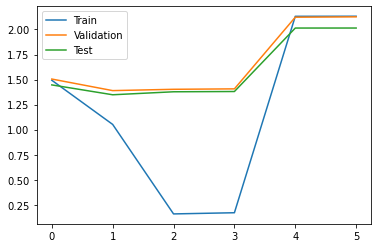

In [14]:
# Setup algorithm using SVD
# Variando la tasa de aprendizaje
rmse = []   
for r in [0,0.001,0.01,0.1,1,10]:
    svd2 = SVD( n_factors = 60, n_epochs = 200, biased = True, lr_all = r, reg_all = 0, init_mean = 0, init_std_dev = 0.01, verbose = False )
    svd2.fit(train_set)
    pu2 = svd2.pu
    predictions_train = svd2.test( train_data_2 )
    predictions_validation = svd2.test( validation_data )
    predictions_test = svd2.test( test_data )

    rmse_train=accuracy.rmse( predictions_train, verbose = False )
    rmse_validation=accuracy.rmse( predictions_validation, verbose = False )
    rmse_test=accuracy.rmse( predictions_test, verbose = False )

    rmse.append([rmse_train,rmse_validation,rmse_test])

    print("-----------", r)
    print("Train:", rmse_train)
    print("Validation:", rmse_validation)
    print("Test:", rmse_test)
    print("-----------", r)

df = pd.DataFrame(rmse, columns=["Train", "Validation", "Test"])
df.plot()